# Fitting SEDs with a Custom Model

This tutorial will walk you through customizing the B5 model and fitting the same AT2022cmc data as the first tutorial.

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import syncfit

## Reading in the Data

This is the same as the first tutorial, it is just here as a refresher.

In [2]:
# read in the data
cmc = pd.read_csv('AT2022cmc_Andreoni2022.txt')
cmc

,facility,date,dt,nu,F_nu,F_err,upperlimit
0,NOEMA,2022-03-24 22:14,41.48,86.0,3914,30,True
1,NOEMA,2022-03-24 22:14,41.48,102.0,3609,34,False
2,NOEMA,2022-03-25 00:45,41.58,136.0,3045,41,False
3,NOEMA,2022-03-25 00:45,41.58,152.0,2750,51,False
4,VLA,2022-03-31 04:08,47.73,31.4,2130,30,False
5,VLA,2022-03-31 04:08,47.73,33.5,2260,30,False
6,VLA,2022-03-31 04:08,47.73,35.6,2350,40,False
7,VLA,2022-03-31 04:08,47.73,37.5,2360,40,True
8,VLA,2022-03-31 04:13,47.73,8.5,270,12,False
9,VLA,2022-03-31 04:13,47.73,9.5,336,11,False


Text(0, 0.5, 'Flux [uJy]')

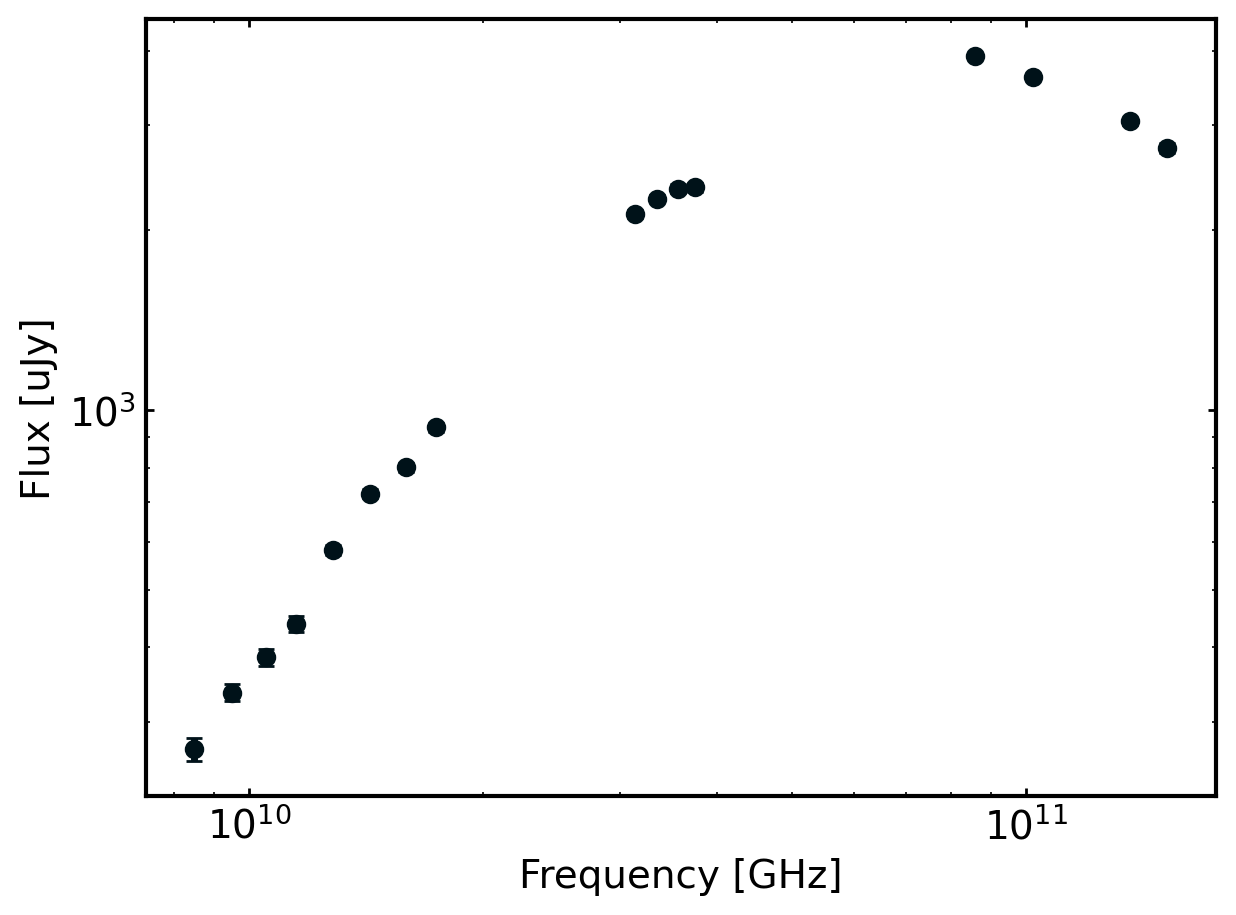

In [3]:
# now plot the SED
fig, ax = plt.subplots(1)

ax.errorbar(cmc.nu*1e9, cmc.F_nu, yerr=cmc.F_err, fmt='o')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Flux [uJy]')

## Fitting the Data

Now that we have the AT2022cmc data read in, we can fit it using syncfit. Let's first just use the default B5 model like we did in the first tutorial.

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2602.04it/s]


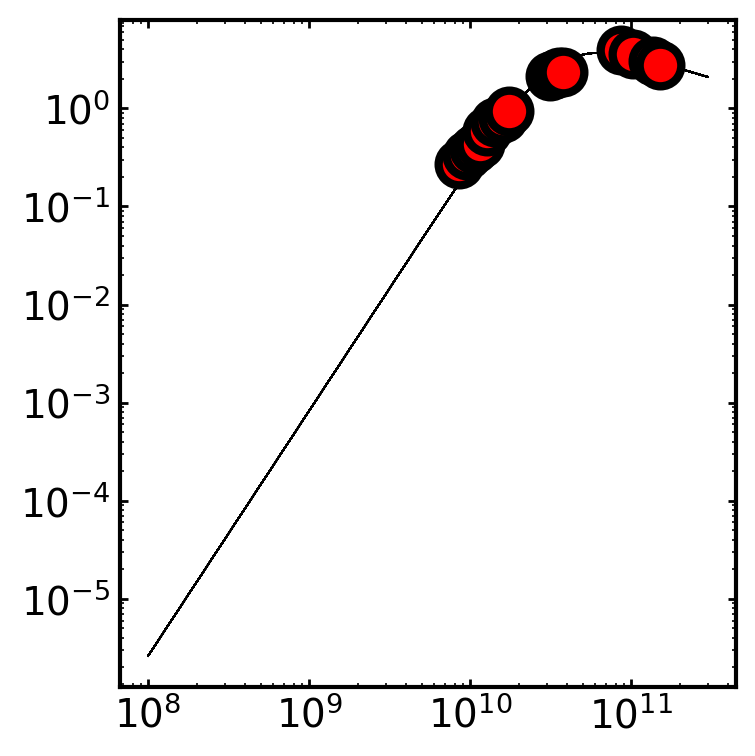

\mathrm{p} = 2.01e+00_{-0.005}^{0.487}
\mathrm{log F_v} = 7.87e-01_{-0.119}^{0.053}
\mathrm{log nu_a} = 1.05e+01_{-1.051}^{0.007}


In [4]:
# the initial guesses
theta_init = [
    3, # p-value guess
    1, # initial log_F_nu guess
    10, # initial nu_a guess, this is all we need for B5!
]

# the number of walkers
# 32 is usually fine, more makes it slower! 
nwalkers = 32

# now define the number of iterations
# something small for now to make it fast, 
# usually ~2000 gives a converging chaing
niter = 500

# now we can fit the data
sampler = syncfit.do_emcee(
    theta_init = theta_init,
    nu = cmc.nu,
    F_muJy = cmc.F_nu,
    F_error = cmc.F_err,
    model = syncfit.models.B5, # get the model from syncfit
    niter = niter,
    nwalkers = nwalkers
)

# Then let's just check how the fit looks
syncfit.analysis.plot_best_fit(
    model = syncfit.models.B5,
    sampler = sampler,
    
    # be careful with units for the data
    # the frequency must be in GHz space
    # and the flux densities must be in mJy space
    nu = cmc.nu*1e9,
    F = cmc.F_nu*1e-3
)

# print out the constraints we get
labels = syncfit.models.B5.get_labels() 
constraints = syncfit.analysis.get_bounds(sampler, labels, toprint=True)

Which has a pretty good looking fit! But, let's see if we can make it better by customizing the B5 model a little more! For this tutorial, we are going to modify the prior function, called `lnprior`, but some other methods that can be customized are `SED` (the model itself) and `loglik` (the likelihood function which, by default, is just gaussian).

To do this, we use the decorator `@syncfit.models.B5.override`. All of the models, including the generic `SyncfitModel` model, have this override decorator which allows you to customize that specific method of the model class. If you want to use the generic `SyncfitModel` instead of one of the other builtin models please note that you will need to define `lnprior`, `SED`, and `get_labels` using this decorator.

In [5]:
@syncfit.models.B5.override
def lnprior(theta, p=None, **kwargs):
    '''
    Our customized lnprior function. This needs the arguments
    that it has and no more or less! Otherwise it won't work 
    when we actually try to run the MCMC.
    '''

    # All of this is copied from the source code and is fine to leave
    # since it is just unpacking the theta value
    if p is None:
        p, log_F_nu, log_nu_a= theta
    else:
        log_F_nu, log_nu_a = theta

    # However, here we want to change things to narrow the
    # priors on all three parameters
    if 2.9 < p < 3.1 and -1 < log_F_nu < 1 and 9 < log_nu_a < 11:
        return 0.0

    else:
        return -np.inf

In this case, since we've just overwritten a method of the B5 model class directly, we can just pass in the B5 model again.

  0%|                                                                                           | 0/500 [00:00<?, ?it/s]/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2566.89it/s]


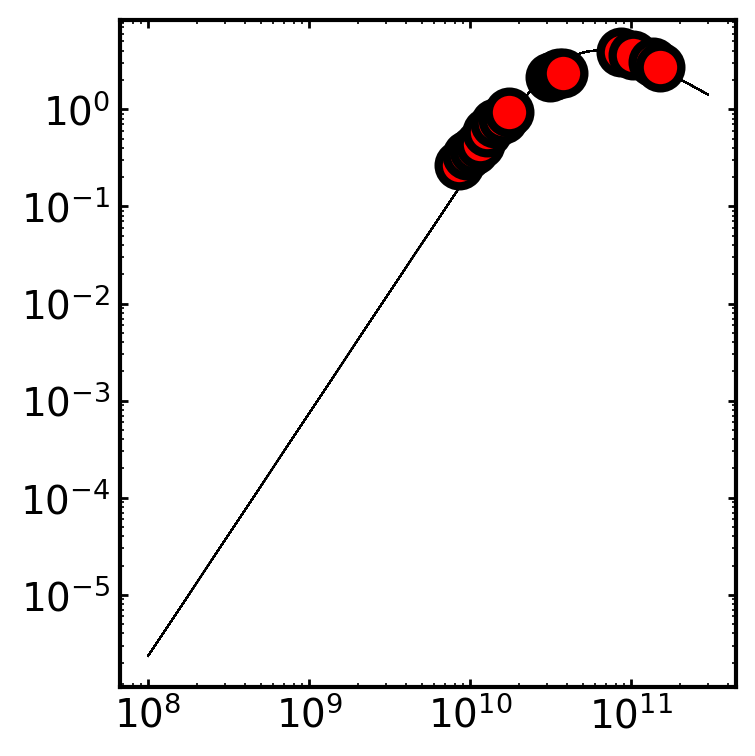

\mathrm{p} = 2.91e+00_{-0.007}^{0.063}
\mathrm{log F_v} = 9.58e-01_{-0.014}^{0.004}
\mathrm{log nu_a} = 1.06e+01_{-0.110}^{0.003}


In [6]:
# now we can fit the data
sampler = syncfit.do_emcee(
    theta_init = theta_init,
    nu = cmc.nu,
    F_muJy = cmc.F_nu,
    F_error = cmc.F_err,
    model = syncfit.models.B5, # use the same model here!
    niter = niter,
    nwalkers = nwalkers
)

# Then let's just check how the fit looks
syncfit.analysis.plot_best_fit(
    model = syncfit.models.B5,
    sampler = sampler,
    
    # be careful with units for the data
    # the frequency must be in GHz space
    # and the flux densities must be in mJy space
    nu = cmc.nu*1e9,
    F = cmc.F_nu*1e-3
)

# print out the constraints we get
labels = syncfit.models.B5B3.get_labels() 
constraints = syncfit.analysis.get_bounds(sampler, labels, toprint=True)

You can also do this customization by subclassing. I know subclassing and learning what that means can be somewhat of a steep learning curve. But, it is the best way to reduce code redundancy for this type of software! If you need to refresh your memory on subclassing in python, I recommend this tutorial for a quick overview: https://www.geeksforgeeks.org/create-a-python-subclass/. The basic idea though, is that when you subclass you get all of the methods from the superclass that you are using. 

So, now let's actually do this customization! In this case, we use the superclass `syncfit.models.B5` which itsels subclasses the `syncfit.models.SyncfitModel` superclass. 

In [7]:
class CustomB5(syncfit.models.B5):
    
    def lnprior(theta, p=None, **kwargs):
        '''
        Our customized lnprior function. This needs the arguments
        that it has and no more or less! Otherwise it won't work 
        when we actually try to run the MCMC.
        '''
        
        # All of this is copied from the source code and is fine to leave
        # since it is just unpacking the theta value
        if p is None:
            p, log_F_nu, log_nu_a= theta
        else:
            log_F_nu, log_nu_a = theta
            
        # However, here we want to change things to narrow the
        # priors on all three parameters
        if 2.9 < p < 3.1 and -1 < log_F_nu < 1 and 9 < log_nu_a < 11:
            return 0.0

        else:
            return -np.inf    

Now that we've customized the B5 model with some more stringent priors, let's try fitting
our data again!

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2642.76it/s]


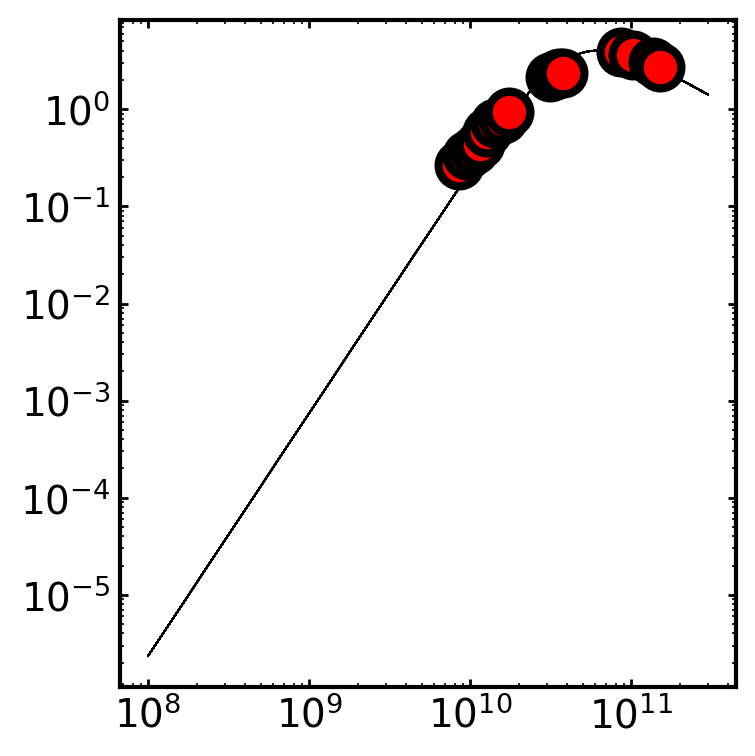

\mathrm{p} = 2.91e+00_{-0.009}^{0.065}
\mathrm{log F_v} = 9.58e-01_{-0.318}^{0.004}
\mathrm{log nu_a} = 1.06e+01_{-1.299}^{0.003}


In [8]:
# now we can fit the data
sampler = syncfit.do_emcee(
    theta_init = theta_init,
    nu = cmc.nu,
    F_muJy = cmc.F_nu,
    F_error = cmc.F_err,
    model = CustomB5, # use our custom model here!
    niter = niter,
    nwalkers = nwalkers
)

# Then let's just check how the fit looks
syncfit.analysis.plot_best_fit(
    model = syncfit.models.B5,
    sampler = sampler,
    
    # be careful with units for the data
    # the frequency must be in GHz space
    # and the flux densities must be in mJy space
    nu = cmc.nu*1e9,
    F = cmc.F_nu*1e-3
)

# print out the constraints we get
labels = syncfit.models.B5B3.get_labels() 
constraints = syncfit.analysis.get_bounds(sampler, labels, toprint=True)

At first glance, the fit looks very similar to the first fit we had. But, we know that we were finding somewhat unphysical values ($p=2.01$ doesn't really make sense) before changing the priors. Although, this also serves as a warning that choosing your priors is very important for the constraints you get! It is usually a good idea to try different sets of priors based on your own intuition.